# Pymagicc Usage Examples

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
# NBVAL_IGNORE_OUTPUT
from pprint import pprint

import pymagicc
from pymagicc import (
    MAGICC6,
    rcp26, rcp45, rcp60, rcp85, scenarios
)

<IPython.core.display.Javascript object>

## Scenarios

The four RCP scenarios are already preloaded in Pymagicc. They are loaded as `MAGICCData` objects with `data` and `metadata` attributes. `metadata` contains metadata

In [3]:
type(rcp26)

pymagicc.io.MAGICCData

In [4]:
pprint(rcp26.metadata)

{'date': '26/11/2009 11:29:06; MAGICC-VERSION: 6.3.09, 25 November 2009',
 'header': '20\n'
           '41\n'
           'RCP3PD\n'
           'HARMONISED, EXTENDED FINAL RCP3-PD (Peak&Decline) NOV26; '
           'RCP3PD-Contact: IMAGE group, Detlef van Vuuren '
           '(Detlef.vanVuuren@pbl.nl)\n'
           'DATE: 26/11/2009 11:29:06; MAGICC-VERSION: 6.3.09, 25 November '
           '2009\n'
           'Final RCP3PD with constant emissions after 2100 using the default '
           'RCPtool MAGICC6.3 settings. Compiled by: '
           'malte.meinshausen@pik-potsdam.de'}


`data` contains a Pandas dataframe with all the scenario data.

In [5]:
rcp26.data.head()

,variable,todo,unit,region,climate_model,model,scenario,time,value
160,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,7.8048
160,Emissions|BC,SET,Mt BC / yr,World|Bunkers,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,0.1361
160,Emissions|BC,SET,Mt BC / yr,World|R5ASIA,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,3.0468
160,Emissions|BC,SET,Mt BC / yr,World|R5LAM,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,0.9311
160,Emissions|BC,SET,Mt BC / yr,World|R5MAF,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,1.8766


However, `MAGICCData` subclasses pyam's `IamDataFrame` so we can access many of the dataframe's attributes directly, e.g.

In [6]:
rcp26.head()

,variable,todo,unit,region,climate_model,model,scenario,time,value
160,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,7.8048
160,Emissions|BC,SET,Mt BC / yr,World|Bunkers,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,0.1361
160,Emissions|BC,SET,Mt BC / yr,World|R5ASIA,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,3.0468
160,Emissions|BC,SET,Mt BC / yr,World|R5LAM,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,0.9311
160,Emissions|BC,SET,Mt BC / yr,World|R5MAF,unspecified,IMAGE,RCP26,2000-07-12 00:00:00,1.8766


In [7]:
rcp26["variable"]

160     Emissions|BC
160     Emissions|BC
160     Emissions|BC
160     Emissions|BC
160     Emissions|BC
160     Emissions|BC
160     Emissions|BC
161     Emissions|BC
161     Emissions|BC
161     Emissions|BC
161     Emissions|BC
161     Emissions|BC
161     Emissions|BC
161     Emissions|BC
162     Emissions|BC
162     Emissions|BC
162     Emissions|BC
162     Emissions|BC
162     Emissions|BC
162     Emissions|BC
162     Emissions|BC
163     Emissions|BC
163     Emissions|BC
163     Emissions|BC
163     Emissions|BC
163     Emissions|BC
163     Emissions|BC
163     Emissions|BC
164     Emissions|BC
164     Emissions|BC
           ...      
95     Emissions|SOx
95     Emissions|SOx
96     Emissions|SOx
96     Emissions|SOx
96     Emissions|SOx
96     Emissions|SOx
96     Emissions|SOx
96     Emissions|SOx
96     Emissions|SOx
97     Emissions|SOx
97     Emissions|SOx
97     Emissions|SOx
97     Emissions|SOx
97     Emissions|SOx
97     Emissions|SOx
97     Emissions|SOx
98     Emissi

The rcp's contain the following emissions with the following units

In [8]:
rcp26.variables(include_units=True)

,variable,unit
0,Emissions|BC,Mt BC / yr
1,Emissions|C2F6,kt C2F6 / yr
2,Emissions|C6F14,kt C6F14 / yr
3,Emissions|CF4,kt CF4 / yr
4,Emissions|CH4,Mt CH4 / yr
5,Emissions|CO,Mt CO / yr
6,Emissions|CO2|MAGICC AFOLU,Gt C / yr
7,Emissions|CO2|MAGICC Fossil and Industrial,Gt C / yr
8,Emissions|HFC125,kt HFC125 / yr
9,Emissions|HFC134a,kt HFC134a / yr


The regions included are

In [9]:
rcp26.regions()

0            World
1    World|Bunkers
2     World|R5ASIA
3      World|R5LAM
4      World|R5MAF
5     World|R5OECD
6      World|R5REF
Name: region, dtype: object

A plot of four categories in RCP3PD

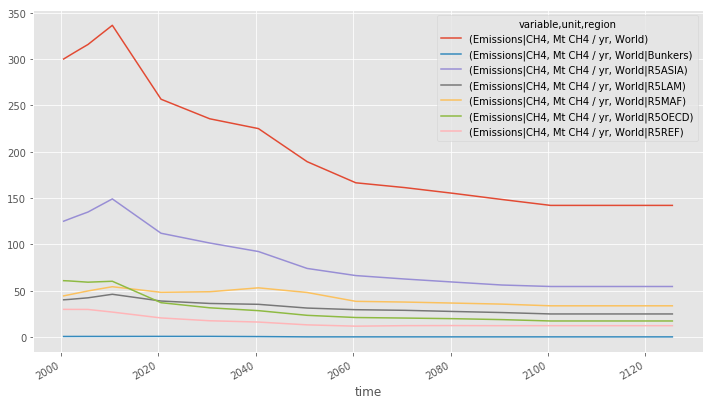

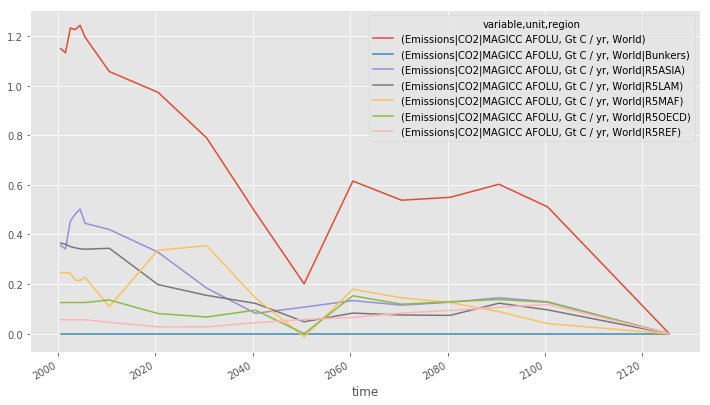

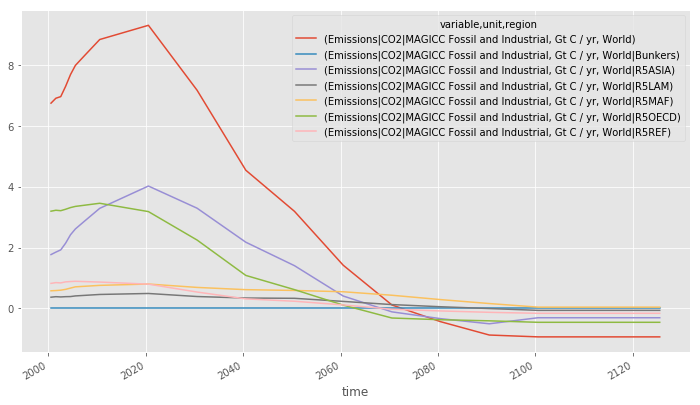

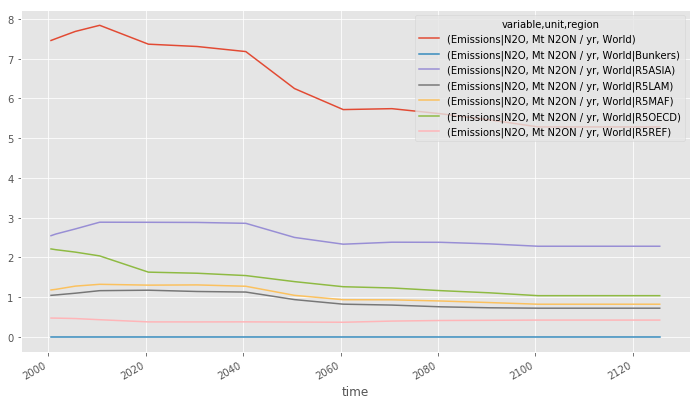

In [10]:
categories_to_plot = [
    "Emissions|" + v 
    for v in ["CO2|MAGICC Fossil and Industrial", "CO2|MAGICC AFOLU", "CH4", "N2O"]
]
rcp26.filter(
    variable=categories_to_plot,
    year=range(1000, 2150)
).pivot_table(
    index="time", 
    columns=["variable", "unit", "region"],
    aggfunc="sum"
).groupby(level="variable", axis=1).plot(figsize=(12, 7));

Fossil fuel emissions for the four RCP scenarios.

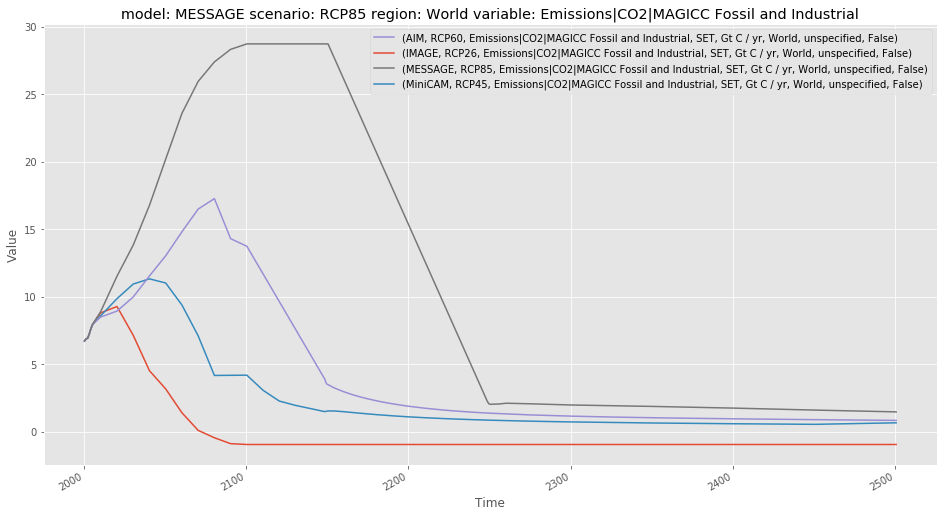

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
for name, scen in scenarios.items():
    scen.filter(
        variable="Emissions|CO2|MAGICC Fossil and Industrial",
        region="World"
    ).line_plot(ax=ax, x="time");

## Running MAGICC

A single `pymagicc` run takes a couple of seconds and returns the same object as used above. If not on Windows, the very first run might be slower due to setting up Wine. Multiple runs can be faster as setup times are reduced and other options speed things up even further e.g. limiting output to the subset of interest, using binary output formats.

In [12]:
# NBVAL_IGNORE_OUTPUT
%time results = pymagicc.run(rcp26)

CPU times: user 2.62 s, sys: 222 ms, total: 2.84 s
Wall time: 6.22 s


In [13]:
def multiple_runs():
    with MAGICC6() as magicc:
        for name, scen in scenarios.items():
            results = magicc.run(scen)

In [14]:
# NBVAL_IGNORE_OUTPUT
%time multiple_runs()

CPU times: user 9.93 s, sys: 767 ms, total: 10.7 s
Wall time: 19.9 s


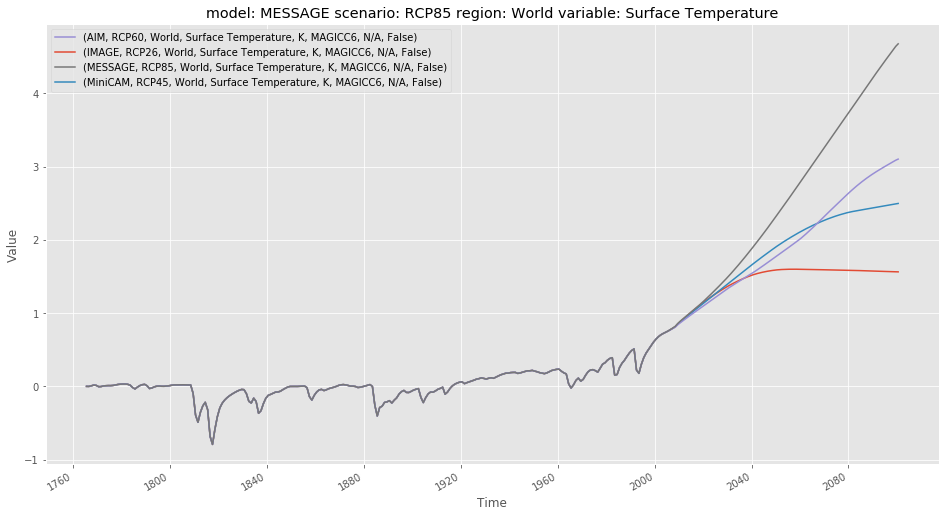

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
with MAGICC6() as magicc:
    for name, scen in scenarios.items():
        results = magicc.run(scen)
        results.filter(
            variable="Surface Temperature",
            region="World"
        ).line_plot(ax=ax, x="time");

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

In [16]:
low = pymagicc.run(rcp45, core_climatesensitivity=1.5)
default = pymagicc.run(rcp45, core_climatesensitivity=3)
high = pymagicc.run(rcp45, core_climatesensitivity=4.5)

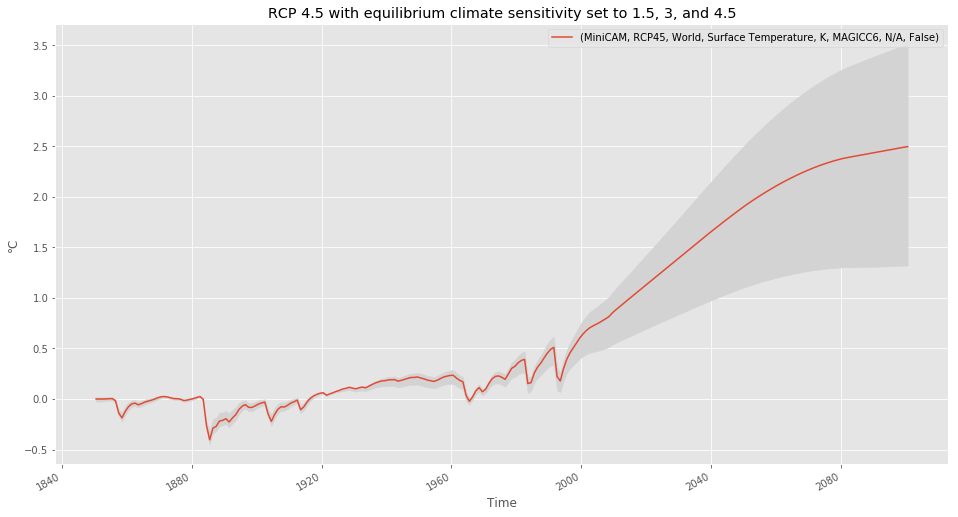

In [17]:
filtering = {
    "variable": "Surface Temperature",
    "region": "World",
    "year": range(1850, 2101),
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
plt.fill_between(
    low.filter(**filtering)["time"].values,
    low.filter(**filtering)["value"].values,
    high.filter(**filtering)["value"].values,
    color="lightgray"
)
default.filter(**filtering).line_plot(ax=ax, x="time")

plt.title(
    "RCP 4.5 with equilibrium climate sensitivity set to 1.5, 3, and 4.5"
)
plt.ylabel("°C");